In [61]:
import numpy as np 
import pandas as pd 
import random
import matplotlib.pyplot as plt 
import os
pd.set_option('display.max_rows', 200)
%matplotlib inline

In [62]:
# define folder where data resides 
DATAFOLDER = "/Users/snuffles753/Documents/NYU-GSAS/ds1003/term-project/data"

In [63]:
import csv
import os
first = True
with open(os.path.join(DATAFOLDER,'final_subset.csv'), 'w') as f_write:
    with open(os.path.join(DATAFOLDER,'decision_sched_merge_adjdate.csv'), "r") as f:
        read = csv.DictReader(f, delimiter=',')
        for row in read:
            if first:
                f_write.write("case_id,proceeding_id,year,judge_id,nationality,lawyer,city_id,decision\n")
                first = False
            else:
                f_write.write("{},{},{},{},{},{},{},{}\n".format(row['idncase'], row['idnproceeding'],
                                                              row['input_year'], row['judgeid'],
                                                              row['nat'],row['lawyer'],row['cityid'],
                                                              row['dec_string']))

In [64]:
from pyspark.sql import SparkSession
from pyspark import SparkContext
# conf = SparkConf().setAppName("App")
# conf = conf.setMaster('local[*]').set('spark.executor.memory', '5G')\
# .set('spark.driver.memory', '5G')\
# .set('spark.driver.maxResultSize', '5G')

sc = SparkContext.getOrCreate()
sqlContext=SQLContext(sc);


In [66]:
# spark=sqlContext.sparkSession
# master_dchen = spark.read.csv(os.path.join(DATAFOLDER,'decision_sched_merge_adjdate.csv'),
#                 header=True,mode="DROPMALFORMED")
# master_dchen.printSchema()
# master_dchen.show(3)
master_dchen = None

In [67]:
spark=sqlContext.sparkSession

tblAppeal = spark.read.csv(os.path.join(DATAFOLDER, 'raw/tblAppeal.csv'),
                header=True,mode="DROPMALFORMED")
tblAppeal = tblAppeal.dropDuplicates(['idncase'])

tblAppeal.printSchema()
tblAppeal.show(3)
print(tblAppeal.count())

root
 |-- idnAppeal: string (nullable = true)
 |-- idncase: string (nullable = true)
 |-- idnProceeding: string (nullable = true)
 |-- strAppealCategory: string (nullable = true)
 |-- strAppealType: string (nullable = true)
 |-- datAppealFiled: string (nullable = true)
 |-- strFiledBy: string (nullable = true)
 |-- datAttorneyE27: string (nullable = true)
 |-- datBIADecision: string (nullable = true)
 |-- strBIADecision: string (nullable = true)
 |-- strBIADecisionType: string (nullable = true)
 |-- strCaseType: string (nullable = true)
 |-- strLang: string (nullable = true)
 |-- strNat: string (nullable = true)
 |-- strProceedingIHP: string (nullable = true)
 |-- strCustody: string (nullable = true)
 |-- strProbono: string (nullable = true)

+---------+-------+-------------+-----------------+-------------+-------------------+----------+--------------+-------------------+--------------+------------------+-----------+-------+------+----------------+----------+----------+
|idnAppeal|idnc

In [71]:
spark=sqlContext.sparkSession
#case_id,proceeding_id,year,judge_id,nationality,lawyer,city_id
nationals = spark.read.csv(os.path.join(DATAFOLDER,'final_subset.csv'),
                header=True,mode="DROPMALFORMED")
print(nationals.count())
nationals = nationals.dropDuplicates(['case_id', 'year'])
nationals.printSchema()
nationals.show(10)
print(nationals.count())

nationalities = spark.read.csv(os.path.join(DATAFOLDER,'raw/tblLookupNationality.csv'),
                header=False,mode="DROPMALFORMED")


#5664752
#4508147 - without year drop
#4976392 - with year drop

5664752
root
 |-- case_id: string (nullable = true)
 |-- proceeding_id: string (nullable = true)
 |-- year: string (nullable = true)
 |-- judge_id: string (nullable = true)
 |-- nationality: string (nullable = true)
 |-- lawyer: string (nullable = true)
 |-- city_id: string (nullable = true)
 |-- decision: string (nullable = true)

+-------+-------------+------+--------+-----------+------+-------+--------------------+
|case_id|proceeding_id|  year|judge_id|nationality|lawyer|city_id|            decision|
+-------+-------------+------+--------+-----------+------+-------+--------------------+
|2046985|      3200124|2004.0|     325|         MO|     1|      9|      RELIEF GRANTED|
|2047073|      3200025|2003.0|     325|         KU|     0|     25|          TERMINATED|
|2047074|      3200026|2003.0|     402|         MX|     0|     15|              REMOVE|
|2047255|            8|1987.0|     335|         CA|     1|     28|           TERMINATE|
|2047428|        91604|1998.0|     134|         MX

In [129]:
# from pyspark.sql.types import StructType, StructField, IntegerType, StringType

# schema = StructType([
#     StructField("member_srl", IntegerType(), True),
#     StructField("click_day", StringType(), True),
#     StructField("productid", StringType(), True)])

nationalities = spark.read.csv(os.path.join(DATAFOLDER,'raw/tblLookupNationality.csv'),
                header=False, mode="DROPMALFORMED")
nationalities = nationalities.select(nationalities._c1.alias('nat_code'), nationalities._c2.alias('country'))
nationalities.createOrReplaceTempView("NATIONALITIES")

nationalities.show()

+--------+-------------------+
|nat_code|            country|
+--------+-------------------+
|      ??|UNKNOWN NATIONALITY|
|      AB|              ARUBA|
|      AC|ANTIGUA AND BARBUDA|
|      AF|        AFGHANISTAN|
|      AG|            ALGERIA|
|      AL|            ALBANIA|
|      AM|            ARMENIA|
|      AN|            ANDORRA|
|      AO|             ANGOLA|
|      AR|          ARGENTINA|
|      AS|          AUSTRALIA|
|      AU|            AUSTRIA|
|      AV|           ANGUILLA|
|      AZ|         AZERBAIJAN|
|      BA|            BAHRAIN|
|      BB|           BARBADOS|
|      BC|           BOTSWANA|
|      BD|            BERMUDA|
|      BE|            BELGIUM|
|      BF|            BAHAMAS|
+--------+-------------------+
only showing top 20 rows



In [125]:
nationals.createOrReplaceTempView("NATIONALS")

tblAppeal.createOrReplaceTempView("APPEALS")
appeal_caseids = spark.sql("SELECT DISTINCT idncase as caseId FROM APPEALS")
appeal_caseids.createOrReplaceTempView("APPEAL_CASE_IDS")

appeals_sql = """
SELECT B.case_id, B.nationality
FROM
(
SELECT M.case_id, A.caseId, M.nationality
FROM NATIONALS M
JOIN APPEAL_CASE_IDS A
ON M.case_id = A.caseId
) B
"""
appeals = spark.sql(appeals_sql)
# appeals.show()
# num_appeals = appeals.count()
# print(num_appeals)

non_appeals_sql = """
SELECT B.case_id, B.nationality
FROM
(
SELECT M.case_id, A.caseId, M.nationality
FROM NATIONALS M
LEFT JOIN APPEAL_CASE_IDS A
ON M.case_id = A.caseId
) B
WHERE caseId IS NULL
"""
non_appeals = spark.sql(non_appeals_sql)
# non_appeals.show()
# num_non_appeals = non_appeals.count()
# print(num_non_appeals)
        
appeals.createOrReplaceTempView("APPEALS_POP")
non_appeals.createOrReplaceTempView("NON_APPEALS_POP")

In [25]:
num_appeals = appeals.count()
num_non_appeals = non_appeals.count()

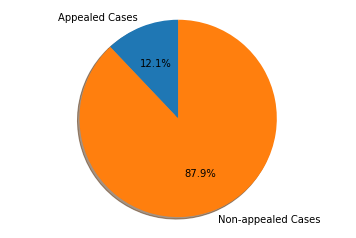

In [26]:


labels = 'Appealed Cases', 'Non-appealed Cases'
sizes = [num_appeals, num_non_appeals]

fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%', shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

In [27]:
print(num_appeals)
print(num_non_appeals)

544855
3963292


In [28]:
appeals_sql = """
SELECT *
FROM
(
SELECT nationality, ROUND(COUNT(case_id) *100 / 544855, 2) as percentage, COUNT(case_id) as count
FROM APPEALS_POP
GROUP BY nationality
) B
ORDER BY B.count desc
LIMIT 10
"""
appeals_nat = spark.sql(appeals_sql)
appeals_nat.show()

non_appeals_sql = """
SELECT *
FROM
(
SELECT nationality, ROUND(COUNT(case_id) *100 / 3963292, 2) as percentage, COUNT(case_id) as count
FROM NON_APPEALS_POP
GROUP BY nationality
) B
ORDER BY B.count desc
LIMIT 10
"""
non_appeals_nat = spark.sql(non_appeals_sql)
non_appeals_nat.show()

+-----------+----------+------+
|nationality|percentage| count|
+-----------+----------+------+
|         MX|     21.93|119488|
|         CH|      9.07| 49434|
|         ES|      8.02| 43688|
|         HA|      6.82| 37154|
|         GT|      5.65| 30758|
|         CO|      3.82| 20833|
|         NU|       3.5| 19075|
|         IN|      2.51| 13682|
|         HO|      2.33| 12676|
|         DR|      2.11| 11486|
+-----------+----------+------+

+-----------+----------+-------+
|nationality|percentage|  count|
+-----------+----------+-------+
|         MX|     41.38|1639911|
|         ES|      9.78| 387775|
|         GT|      7.43| 294294|
|         HO|      6.83| 270866|
|         CH|      2.55| 100869|
|         CU|      2.15|  85284|
|         DR|      1.97|  78027|
|         CO|      1.88|  74444|
|         NU|      1.87|  74093|
|         BR|      1.85|  73282|
+-----------+----------+-------+



In [72]:
nationals.createOrReplaceTempView("NATIONALS")
tblAppeal.createOrReplaceTempView("APPEALS")
appeal_caseids = spark.sql("SELECT DISTINCT idncase as caseId FROM APPEALS")
appeal_caseids.createOrReplaceTempView("APPEAL_CASE_IDS")


In [74]:
distinct_sql = """
SELECT DISTINCT decision
FROM NATIONALS
"""
decisions = spark.sql(distinct_sql)
decisions.show(20, False)

+------------------------------------------------------+
|decision                                              |
+------------------------------------------------------+
|RELIEF GRANTED                                        |
|GRANT                                                 |
|SUSTAIN                                               |
|VOLUNTARY DEPARTURE                                   |
|null                                                  |
|FAILURE TO PROSECUTE (DHS CASES ONLY)                 |
|OTHER ADMINISTRATIVE COMPLETION                       |
|TRANSFER                                              |
|PROSECUTORIAL DISCRETION Ð TERMINATED                 |
|DISMISSED                                             |
|WITHDRAW                                              |
|HAITIAN                                               |
|VACATE - DHS DECISION AND ALIEN'S CLAIMED STATUS VALID|
|VACATE - DHS DECISION AND CREDIBLE FEAR               |
|DEPORT                        

In [79]:
appeal_proportion_by_year_sql = """
SELECT year, COUNT(caseId) / COUNT(case_id) * 100 as appeal_rate, 
COUNT(caseId) as appeal_ct, 
COUNT(case_id) case_ct
FROM
(
SELECT M.case_id, A.caseId, M.nationality, M.year
FROM NATIONALS M
LEFT JOIN APPEAL_CASE_IDS A
ON M.case_id = A.caseId
WHERE M.decision NOT IN ('GRANT','RELIEF GRANTED')
) B
GROUP BY year
ORDER BY year
"""
    
appeal_proportion_by_year = spark.sql(appeal_proportion_by_year_sql)
df_pd_appeals_by_year = appeal_proportion_by_year.toPandas()

In [106]:
df_pd_appeals_by_year.dropna(inplace=True)
df_pd_appeals_by_year.year = df_pd_appeals_by_year.year.astype(float)
df_pd_appeals_by_year.year = df_pd_appeals_by_year.year.astype(int)
df_pd_appeals_by_year = df_pd_appeals_by_year.query('year>1975')
df_pd_appeals_by_year.head(30)


,year,appeal_rate,appeal_ct,case_ct
25,1976,30.845771,62,201
26,1977,31.250000,70,224
27,1978,30.463576,92,302
28,1979,30.215827,168,556
29,1980,30.802603,284,922
30,1981,32.286996,720,2230
31,1982,40.122200,1182,2946
32,1983,42.379651,2016,4757
33,1984,44.446629,4522,10174
34,1985,33.117903,7379,22281


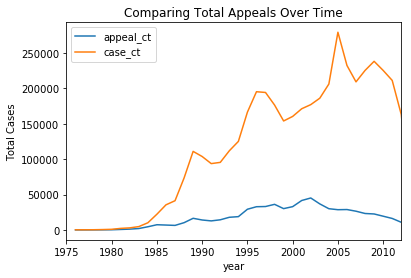

In [89]:
    
plt.figure()
df_pd_total_appeals_by_year = df_pd_appeals_by_year.drop(['appeal_rate'], axis=1)
df_pd_total_appeals_by_year.plot(x='year')
plt.title('Comparing Total Appeals Over Time')
plt.xlim(1975,2012)
# plt.ylim(0, 50)
plt.ylabel('Total Cases')

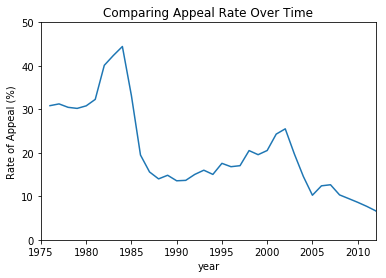

In [91]:
    
plt.figure()
df_pd_appeals_by_year.plot(x='year', legend=None)
plt.title('Comparing Appeal Rate Over Time')
plt.xlim(1975,2012)
plt.ylim(0, 50)
plt.ylabel('Rate of Appeal (%)')

In [ ]:
test_sql = """
SELECT year, COUNT(case_id) / COUNT(caseId) * 100 as grant_rate, 
COUNT(caseId) as appeal_ct, 
COUNT(case_id) grant_ct
FROM APPEAL_CASE_IDS A
LEFT JOIN
(
SELECT case_id, year
FROM NATIONALS
WHERE decision IN ('GRANT','RELIEF GRANTED')
) N
ON N.case_id = A.caseId
GROUP BY year
ORDER BY year
"""

In [103]:
grant_proportion_by_year_sql = """
SELECT year, COUNT(case_id) / COUNT(caseId) * 100 as grant_rate, 
COUNT(caseId) as appeal_ct, 
COUNT(case_id) grant_ct
FROM APPEAL_CASE_IDS A
LEFT JOIN
(
SELECT case_id, year
FROM NATIONALS
WHERE decision IN ('GRANT','RELIEF GRANTED')
) N
ON N.case_id = A.caseId
GROUP BY year
ORDER BY year
"""
    
grant_proportion_by_year = spark.sql(grant_proportion_by_year_sql)
print(grant_proportion_by_year.count())
df_pd_grant_by_year = grant_proportion_by_year.toPandas()

43


In [105]:
df_pd_grant_by_year.dropna(inplace=True)
df_pd_grant_by_year.year = df_pd_grant_by_year.year.astype(float)
df_pd_grant_by_year.year = df_pd_grant_by_year.year.astype(int)
df_pd_grant_by_year = df_pd_grant_by_year.query('year>1975')
df_pd_grant_by_year.head(10)


,year,grant_rate,appeal_ct,grant_ct
5,1976,100.0,6,6
6,1977,100.0,4,4
7,1978,100.0,11,11
8,1979,100.0,21,21
9,1980,100.0,28,28
10,1981,100.0,23,23
11,1982,100.0,72,72
12,1983,100.0,139,139
13,1984,100.0,259,259
14,1985,100.0,392,392


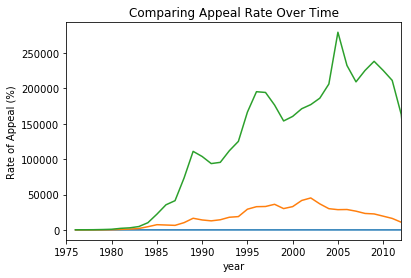

In [100]:
    
plt.figure()
df_pd_grant_by_year.plot(x='year', legend=None)
plt.title('Comparing Appeal Rate Over Time')
plt.xlim(1975,2012)
# plt.ylim(0, 50)
plt.ylabel('Rate of Appeal (%)')

In [135]:
asylum_origin_by_year_sql = """
SELECT *, RANK() OVER (PARTITION BY year ORDER BY case_count DESC) AS nat_rank
FROM
(
SELECT year, nationality, COUNT(case_id) AS case_count
FROM NATIONALS
GROUP BY year, nationality
) N
ORDER BY year
"""
df_asylum_origin_by_year = spark.sql(asylum_origin_by_year_sql)
df_asylum_origin_by_year.createOrReplaceTempView("ASYLUM_ORIGIN")
df_asylum_origin_by_year.show(5)

+----+-----------+----------+--------+
|year|nationality|case_count|nat_rank|
+----+-----------+----------+--------+
|null|         GT|       879|       5|
|null|         ??|      2544|       3|
|null|         ES|      1337|       4|
|null|       null|     12048|       1|
|null|         MX|      4008|       2|
+----+-----------+----------+--------+
only showing top 5 rows



In [147]:
grant_proportion_by_year_sql = """
SELECT *
FROM
(
    SELECT *, case_count - previous_count AS count_diff, 
    nat_rank - previous_rank AS rank_diff,
    ROUND((previous_count - case_count) / previous_count * 100, 2) AS annual_delta
    FROM
    (
        SELECT A1.nationality, 
        A1.year, 
        A1.nat_rank, 
        A1.case_count, 
        A2.nat_rank as previous_rank, 
        A2.case_count as previous_count
        FROM ASYLUM_ORIGIN A1
        JOIN ASYLUM_ORIGIN A2
        ON A1.nationality = A2.nationality AND A1.year = (A2.year + 1)

    ) N
    JOIN NATIONALITIES N2
    ON N.nationality = N2.nat_code
) 
WHERE case_count > 50
ORDER BY annual_delta DESC
"""
    
nat_proportion_by_year = spark.sql(grant_proportion_by_year_sql)
nat_proportion_by_year.show(5)

+-----------+------+--------+----------+-------------+--------------+--------+--------------+----------+---------+------------+
|nationality|  year|nat_rank|case_count|previous_rank|previous_count|nat_code|       country|count_diff|rank_diff|annual_delta|
+-----------+------+--------+----------+-------------+--------------+--------+--------------+----------+---------+------------+
|         BR|2006.0|      11|      2435|            4|         26360|      BR|        BRAZIL|    -23925|        7|       90.76|
|         RO|2013.0|      26|        82|           17|           747|      RO|       ROMANIA|      -665|        9|       89.02|
|         NN|1998.0|     105|        71|           36|           558|      NN|NO NATIONALITY|      -487|       69|       87.28|
|         KE|2013.0|      38|        60|           25|           421|      KE|         KENYA|      -361|       13|       85.75|
|         PL|2013.0|      36|        65|           29|           352|      PL|        POLAND|      -287|

In [148]:
df_nat_proportion_by_year = nat_proportion_by_year.toPandas()

In [149]:
df_nat_proportion_by_year.head(50)


# pd_nat_proportion_by_year.dropna(inplace=True)
# pd_nat_proportion_by_year.year = pd_nat_proportion_by_year.year.astype(float)
# pd_nat_proportion_by_year.year = pd_nat_proportion_by_year.year.astype(int)
# pd_nat_proportion_by_year = pd_nat_proportion_by_year.query('year>1975')
# pd_nat_proportion_by_year.head(100)


,nationality,year,nat_rank,case_count,previous_rank,previous_count,nat_code,country,count_diff,rank_diff,annual_delta
0,BR,2006.0,11,2435,4,26360,BR,BRAZIL,-23925,7,90.76
1,RO,2013.0,26,82,17,747,RO,ROMANIA,-665,9,89.02
2,NN,1998.0,105,71,36,558,NN,NO NATIONALITY,-487,69,87.28
3,KE,2013.0,38,60,25,421,KE,KENYA,-361,13,85.75
4,PL,2013.0,36,65,29,352,PL,POLAND,-287,7,81.53
5,VE,2013.0,24,84,21,450,VE,VENEZUELA,-366,3,81.33
6,TD,2013.0,28,80,24,425,TD,TRINIDAD AND TOBAGO,-345,4,81.18
7,KS,2013.0,24,84,22,437,KS,SOUTH KOREA,-353,2,80.78
8,UK,2013.0,37,61,32,317,UK,UNITED KINGDOM,-256,5,80.76
9,JM,2013.0,11,344,9,1748,JM,JAMAICA,-1404,2,80.32
